In [1]:
import os

import cv2
import numpy as np
import torch
from dreifus.camera import PoseType, CameraCoordinateConvention
from dreifus.image import normalized_torch_to_numpy_img
from dreifus.matrix import Pose
from eg3d.datamanager.nersemble import encode_camera_params
from gaussian_splatting.arguments import PipelineParams2
from gaussian_splatting.gaussian_renderer import render
from gaussian_splatting.scene.cameras import pose_to_rendercam
from matplotlib import pyplot as plt

from gghead.constants import DEFAULT_INTRINSICS
from gghead.model_manager.gghead_model_manager import GGHeadModelFolder

if os.name == 'nt' and 'CONDA_PREFIX' in os.environ:
    # Necessary hack as on some systems, conda sometimes installs C++ headers into "Library/include" instead of just "include" ... 
    os.environ["NVCC_PREPEND_FLAGS"] = f"-I{os.environ['CONDA_PREFIX']}\Library\include"

This notebook showcases how to load a pretrained `GGHead` model and use it to generate 3D Gaussian Heads.  


In [2]:
model_folder = GGHeadModelFolder()
for run_name in model_folder.list_runs():
    available_checkpoints = model_folder.open_run(run_name).list_checkpoint_ids()
    print(f" - {run_name}: {available_checkpoints}")

 - GGHEAD-1_ffhq512: [23200]
 - GGHEAD-2_ffhq1024: [23400]
 - GGHEAD-3_afhq512: [28600]


In [3]:
device = torch.device('cuda')
run_name = 'GGHEAD-1'  # <- Specify which model you would like to load
checkpoint = 23200  # <- Specify the checkpoint to load

model_manager = model_folder.open_run(run_name)

In [4]:
# Load the specified checkpoint
model = model_manager.load_checkpoint(checkpoint, load_ema=True)
model = model.to(device)

In [5]:
# Change the render camera to your liking. Per default, it will render the 3D head from the front at 2.7 units distance
pose_front = Pose(
    matrix_or_rotation=np.eye(3),
    translation=(0, 0, 2.7),
    pose_type=PoseType.CAM_2_WORLD,
    camera_coordinate_convention=CameraCoordinateConvention.OPEN_GL)

c_front = encode_camera_params(pose_front, DEFAULT_INTRINSICS)
c_front = torch.from_numpy(c_front).cuda().unsqueeze(0)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


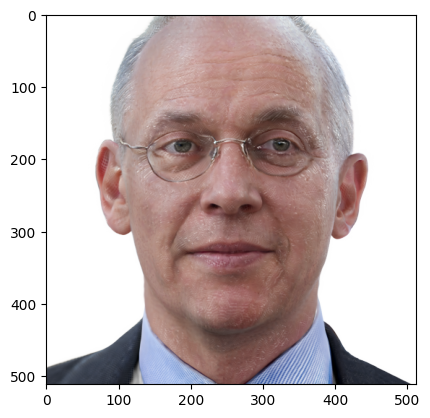

In [6]:
# Generate and render a 3D head corresponding to a random seed 
seed = 0
render_resolution = model_manager.load_dataset_config().resolution

rng = torch.Generator(device)
rng.manual_seed(seed)
z = torch.randn((1, model.z_dim), device='cuda', generator=rng)
w = model.mapping(z, c_front, truncation_psi=0.7)
with torch.no_grad():
    output = model.synthesis(w, c_front, noise_mode='const', return_masks=True, 
                             sh_ref_cam=pose_front, 
                             neural_rendering_resolution=render_resolution,
                             return_uv_map=True)
image = output['image']
image = normalized_torch_to_numpy_img(image[0])
plt.imshow(image)
plt.show()

## [Optional] Obtain depth rendering

C:\Users\kirschstein\AppData\Local\Temp\ipykernel_4632\2401997382.py:7: RuntimeWarning: invalid value encountered in divide
  fixed_depth = depth_map / alpha_masks  # Account for the fact that semi-transparent pixels will have wrong depth since Gaussian contributions don't sum to 1


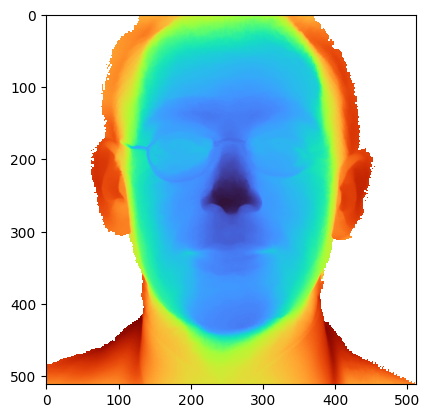

In [7]:
gaussian_model = model._setup_gaussian_model(output.gaussian_attribute_output.gaussian_attributes, 0)
gs_camera = pose_to_rendercam(pose_front, DEFAULT_INTRINSICS.rescale(render_resolution, inplace=False), render_resolution, render_resolution, device=device)
render_output = render(gs_camera, gaussian_model, PipelineParams2(), torch.tensor([1., 1., 1.]).cuda(), return_depth=True)
depth_map = render_output['depth'].permute(1, 2, 0).detach().cpu().numpy()

alpha_masks = ((output.masks[0] + 1)/2).permute(1, 2, 0).detach().cpu().numpy()
fixed_depth = depth_map / alpha_masks  # Account for the fact that semi-transparent pixels will have wrong depth since Gaussian contributions don't sum to 1

plt.imshow(fixed_depth, cmap='turbo')
plt.show()

## [Optional] Derive normals from depth rendering

In [8]:
def convert_depth_to_normal_map(depth_map: np.ndarray, ksize: int = 5, scale: float = 5) -> np.ndarray:
    rows, cols = depth_map.shape

    # Calculate the partial derivatives of depth with respect to x and y
    dx = cv2.Sobel(depth_map, cv2.CV_32F, 1, 0, ksize=ksize, scale=scale)
    dy = cv2.Sobel(depth_map, cv2.CV_32F, 0, 1, ksize=ksize, scale=scale)

    # Compute the normal vector for each pixel
    normal = np.dstack((-dx, -dy, np.ones((rows, cols))))
    norm = np.sqrt(np.sum(normal ** 2, axis=2, keepdims=True))
    normal = np.divide(normal, norm, out=np.zeros_like(normal), where=norm != 0)

    # Map the normal vectors to the [0, 255] range and convert to uint8
    normal = (normal + 1) * 127.5
    normal = normal.clip(0, 255).astype(np.uint8)

    return normal

C:\Users\kirschstein\AppData\Local\Temp\ipykernel_4632\2613311180.py:15: RuntimeWarning: invalid value encountered in cast
  normal = normal.clip(0, 255).astype(np.uint8)


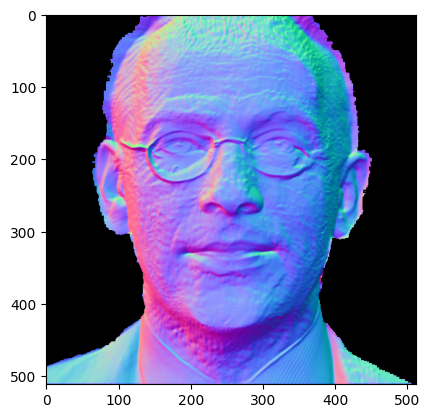

In [9]:
normal_map = convert_depth_to_normal_map(fixed_depth[..., 0])
plt.imshow(normal_map)
plt.show()